# Colima Inversion Examples

In [1]:
%matplotlib inline
from utils import *
import io_utils as io
import vis_utils as vis
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from scipy.stats import beta, expon, truncnorm
from scipy.sparse.linalg import lsqr
from scipy.optimize import minimize
from time import process_time
from functools import reduce
from utils import *
from pandas import ExcelWriter
from pandas import ExcelFile
import xlrd
import re
pd.options.display.float_format = '{:,g}'.format
plt.style.use(['ggplot'])

In [2]:
filename = "./data/colima/colima_real_data.csv"

raw_df, grid = io.import_colima(filename)

grid.to_csv("data/colima/colima_grid.csv", sep=" ", header=False, index=False)

display(raw_df.head())

,Sample no.,Easting,Northing,MassArea,Thickness,"[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)","[0,1)","[1,2)","[2,3)","[3,4)",radius
16,VF00-04a,1499,1506,625.80,60,19.0,31.0,18.0,11.0,6.0,2.0,1.0,1.0,1.0,2124.861643
18,VF00-06a3,1957,1997,417.20,40,7.0,30.0,25.0,17.0,11.0,5.0,1.0,1.0,1.0,2796.043276
17,VF00-05a3,1787,2173,500.64,48,10.0,30.0,24.0,16.0,9.0,3.0,1.0,1.0,1.0,2813.413940
37,VF06-03/5-09,-770,3082,594.51,57,11.0,25.0,25.0,19.0,11.0,4.0,1.0,1.0,1.0,3176.731654
31,VF05-08a3,-1673,3152,125.16,12,10.0,22.0,24.0,16.0,10.0,4.0,2.0,1.0,1.0,3568.477687


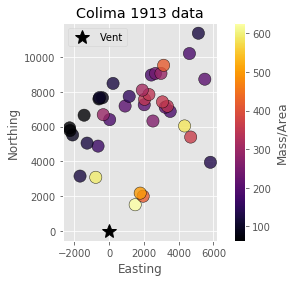

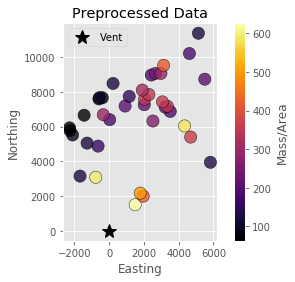

In [3]:
vis.plot_sample(raw_df, vent=(0,0), log=False, title="Colima 1913 data", cbar_label="Mass/Area")
plt.show()
# plt.savefig("colima/all_points.png", dpi=200, format='png')

obs_df = raw_df.copy()

#This is going to be 100 across. Just needs to be the same as the other dfs. 
obs_df["Residual"] = obs_df["MassArea"]/obs_df["MassArea"]*100

vis.plot_sample(obs_df, vent=(0,0), log=False, title="Preprocessed Data", cbar_label="Mass/Area")
# plt.savefig("colima/All_trans.png", dpi=200, format='png')
plt.show()

In [4]:
grid.to_csv("data/colima/colima_grid.csv", sep=" ", header=False, index=False)

t2_df, _, _, _ = io.read_tephra2("data/colima/colima_tephra2_sim_data.txt")

t2_df["Residual"] = t2_df["MassArea"].values/obs_df["MassArea"].values

display(t2_df.head())

,Easting,Northing,Elevation,MassArea,"[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)","[0,1)","[1,2)","[2,3)","[3,4)",radius,Residual
16,1499,1506,0,732.730,23.15290,25.4668,22.2407,15.7304,8.99492,3.44384,0.823464,0.136596,0.010359,2124.861643,1.170869
18,1957,1997,0,691.154,21.35410,24.7682,22.4602,16.5434,9.82586,3.90198,0.968656,0.164832,0.012894,2796.043276,1.656649
17,1787,2173,0,709.841,21.21370,24.7100,22.4801,16.6062,9.88889,3.93999,0.980849,0.167220,0.013114,2813.413940,1.417867
37,-770,3082,0,301.066,13.80220,19.2173,22.1297,20.4626,14.72470,7.12663,2.105690,0.398324,0.032906,3176.731654,0.506410
31,-1673,3152,0,149.680,9.51561,14.8613,20.3208,22.2637,18.49420,10.31720,3.459940,0.706562,0.060698,3568.477687,1.195909


In [5]:
t2_const_df, _, _, _ = io.read_tephra2("data/colima/colima_tephra2_const_wind_sim_data.txt")

t2_const_df["Residual"] = t2_const_df["MassArea"]/obs_df["MassArea"]

display(t2_const_df.head())

,Easting,Northing,Elevation,MassArea,"[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)","[0,1)","[1,2)","[2,3)","[3,4)",radius,Residual
16,1499,1506,2500,1394.460,17.2005,24.2121,24.7779,18.9162,10.8457,3.58293,0.449327,0.015328,0.000028,2124.861643,2.228284
18,1957,1997,2500,1216.150,14.0160,22.3619,24.8640,20.2838,12.7356,4.93885,0.769130,0.030705,0.000063,2796.043276,2.915029
17,1787,2173,2500,1251.000,13.8770,22.2837,24.8861,20.3522,12.8046,4.98427,0.780754,0.031310,0.000064,2813.413940,2.498802
37,-770,3082,2500,359.399,14.8025,22.8299,24.5313,19.4545,12.2828,5.13528,0.922533,0.041096,0.000091,3176.731654,0.604530
31,-1673,3152,2500,134.301,15.3664,23.3283,24.4813,18.8191,11.7036,5.16746,1.079070,0.054478,0.000132,3568.477687,1.073035


In [6]:
config = io.read_tephra2_config("data/colima/colima_config.txt")

globs = {
    "LITHIC_DIAMETER_THRESHOLD": 7.,
    "PUMICE_DIAMETER_THRESHOLD": -1.,
    "AIR_VISCOSITY": 0.000018325,
    "AIR_DENSITY":  1.293,
    "GRAVITY": 9.81,
}

# Update parameters
config["COL_STEPS"] = 20
config["PART_STEPS"] = 9

config["MAX_GRAINSIZE"] = -5
config["MIN_GRAINSIZE"] = 4

# Additional parameter: Constant wind speed
config["WIND_SPEED"] = 10

print("INPUT PARAMETERS:")
display(config)
display(globs)

INPUT PARAMETERS:


{'VENT_EASTING': 0.0,
 'VENT_NORTHING': 0.0,
 'VENT_ELEVATION': 3085.0,
 'PLUME_HEIGHT': 24000.0,
 'ALPHA': 1.02,
 'BETA': 1.56,
 'ERUPTION_MASS': 55000000000.0,
 'MAX_GRAINSIZE': -5,
 'MIN_GRAINSIZE': 4,
 'MEDIAN_GRAINSIZE': -1.8,
 'STD_GRAINSIZE': 2.4,
 'EDDY_CONST': 0.04,
 'DIFFUSION_COEFFICIENT': 4016.0,
 'FALL_TIME_THRESHOLD': 6458.0,
 'LITHIC_DENSITY': 2700.0,
 'PUMICE_DENSITY': 1024.0,
 'COL_STEPS': 20,
 'PART_STEPS': 9,
 'PLUME_MODEL': 2.0,
 'WIND_SPEED': 10}

{'LITHIC_DIAMETER_THRESHOLD': 7.0,
 'PUMICE_DIAMETER_THRESHOLD': -1.0,
 'AIR_VISCOSITY': 1.8325e-05,
 'AIR_DENSITY': 1.293,
 'GRAVITY': 9.81}

,centroid,density,interval,lower,probability,upper
0,-4.5,1024.0,"[-5,-4)",-5.0,0.068338,-4.0
1,-3.5,1024.0,"[-4,-3)",-4.0,0.109203,-3.0
2,-2.5,1024.0,"[-3,-2)",-3.0,0.146694,-2.0
3,-1.5,1024.0,"[-2,-1)",-2.0,0.165650,-1.0
4,-0.5,1024.0,"[-1,0)",-1.0,0.157243,0.0
5,0.5,1233.5,"[0,1)",0.0,0.125474,1.0
6,1.5,1443.0,"[1,2)",1.0,0.084166,2.0
7,2.5,1652.5,"[2,3)",2.0,0.047459,3.0
8,3.5,1862.0,"[3,4)",3.0,0.022496,4.0


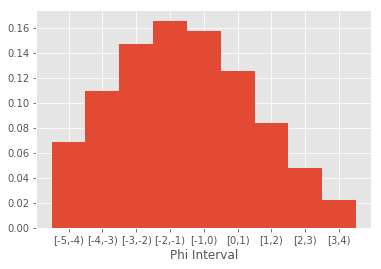

In [7]:
phi_steps = get_phi_steps(config["MIN_GRAINSIZE"], config["MAX_GRAINSIZE"], 
                          config["PART_STEPS"], 
                          config["MEDIAN_GRAINSIZE"], config["STD_GRAINSIZE"],
                          globs["LITHIC_DIAMETER_THRESHOLD"], 
                          globs["PUMICE_DIAMETER_THRESHOLD"], 
                          config["LITHIC_DENSITY"], config["PUMICE_DENSITY"])
step_width = (config["MAX_GRAINSIZE"] - config["MIN_GRAINSIZE"])/config["PART_STEPS"]

display(pd.DataFrame(phi_steps))



probs = [phi["probability"] for phi in phi_steps]
x = [phi["centroid"] for phi in phi_steps]
labels = [phi["interval"] for phi in phi_steps]
fig, ax = plt.subplots()
ax.bar(x, probs, width=1, align="center")
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xlabel("Phi Interval")
plt.show()

In [8]:
t = process_time()
t_tot = process_time()
df_list = []

q_dist = beta(config["ALPHA"],config["BETA"])

grid = obs_df[["Easting", "Northing"]]
wind_angle = np.radians(55)

u = config["WIND_SPEED"]*np.cos(wind_angle)
v = config["WIND_SPEED"]*np.sin(wind_angle)
for phi_step in phi_steps:
    mass_in_phi = config["ERUPTION_MASS"] * phi_step["probability"]
    input_table, gsm_df, sig, vv, tft= gaussian_stack_single_phi(
        grid, 20, config["VENT_ELEVATION"], 
        config["PLUME_HEIGHT"], 
        (config["ALPHA"], config["BETA"]),
        mass_in_phi, (u,v), 
        phi_step["lower"], phi_step["density"], 2500,
        config["DIFFUSION_COEFFICIENT"],
        config["EDDY_CONST"],
        config["FALL_TIME_THRESHOLD"])
    df_list.append(gsm_df.rename(columns={"MassArea":phi_step["interval"]}))


elapsed_time = process_time() - t
print("Forward Sim time: %.5f seconds"%elapsed_time)

t = process_time()
df_merge = reduce(lambda x, y: pd.merge(x, y, on =['Northing', 'Easting']), df_list)
elapsed_time = process_time() - t
print("Dataframe Merge time: %.5f seconds"%elapsed_time)

t = process_time()
df_merge["MassArea"] = np.sum(df_merge[labels], 1)
elapsed_time = process_time() - t
print("Tot M/A calc time: %.5f seconds"%elapsed_time)

t = process_time()
for label in labels:
    df_merge[label] = df_merge.apply(lambda row: (row[label]/row["MassArea"])*100, axis=1) # This operation is much faster

elapsed_time = process_time() - t
print("Phi Wt perc calc time: %.5f seconds"%elapsed_time)

total_time = process_time() - t_tot
print("Total time: %.5f seconds"%total_time)

forward_df = df_merge

# forward_df["MassArea"] = forward_df["MassArea"]*(6991/9469)

forward_df["radius"] = np.sqrt(forward_df["Easting"]**2 + forward_df["Northing"]**2)
forward_df = forward_df.sort_values(by=['radius'])
forward_df["Residual"] = forward_df["MassArea"].values/obs_df["MassArea"].values
display(forward_df.head())

print(u, v)

Forward Sim time: 0.04688 seconds
Dataframe Merge time: 0.01562 seconds
Tot M/A calc time: 0.00000 seconds
Phi Wt perc calc time: 0.01562 seconds
Total time: 0.07812 seconds


,Northing,Easting,"[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)","[0,1)","[1,2)","[2,3)","[3,4)",MassArea,radius,Residual
0,1506,1499,17.023654,24.058691,24.746126,19.010648,10.986457,3.680616,0.476505,0.017266,0.000036,1316.804462,2124.861643,2.104194
1,1997,1957,13.849036,22.187896,24.802962,20.364657,12.884741,5.062941,0.813217,0.034469,0.000080,1148.987823,2796.043276,2.754046
2,2173,1787,13.800371,22.209864,24.864958,20.379976,12.855621,5.043105,0.811521,0.034502,0.000081,1166.987337,2813.413940,2.330991
3,3082,-770,15.561092,23.674710,24.901902,19.059630,11.448421,4.522511,0.794749,0.036892,0.000093,300.904559,3176.731654,0.506139
4,3152,-1673,16.255639,24.321103,24.942842,18.429623,10.768184,4.367639,0.869463,0.045380,0.000126,111.014810,3568.477687,0.886983


5.7357643635104605 8.191520442889917


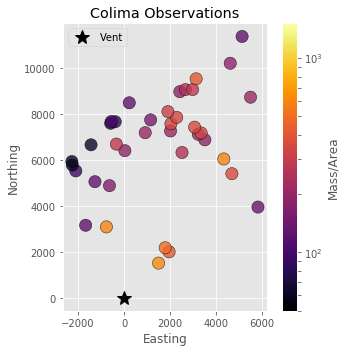

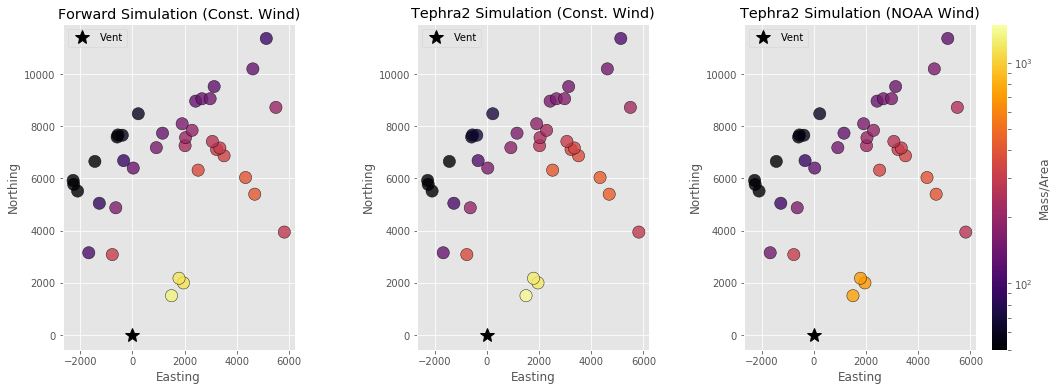

In [10]:

fig, ax = plt.subplots(1, 1, figsize=(5,5))

vis.plot_sample(obs_df, vent=(0,0), log=True, bounds=(50, 1500),
            title="Colima Observations", cbar_label="Mass/Area", ax = ax)
plt.tight_layout()
plt.show()


fig, axs = plt.subplots(1, 3, figsize=(
        18,6), facecolor='w', edgecolor='k')
axs = axs.ravel()

vis.plot_sample(forward_df, vent=(0,0), log=True, bounds=(50, 1500), show_cbar=False,
            title="Forward Simulation (Const. Wind)", cbar_label="Mass/Area", ax=axs[0])
vis.plot_sample(t2_const_df, vent=(0,0), log=True, bounds=(50, 1500), show_cbar=False,
            title="Tephra2 Simulation (Const. Wind)", cbar_label="Mass/Area", ax=axs[1])
vis.plot_sample(t2_df, vent=(0,0), log=True, bounds=(50, 1500),
            title="Tephra2 Simulation (NOAA Wind)", cbar_label="Mass/Area", ax=axs[2])
plt.show()




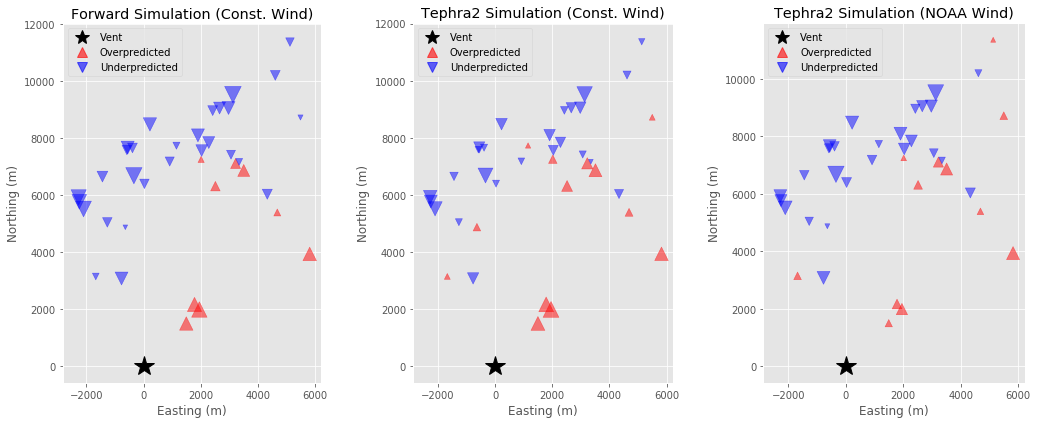

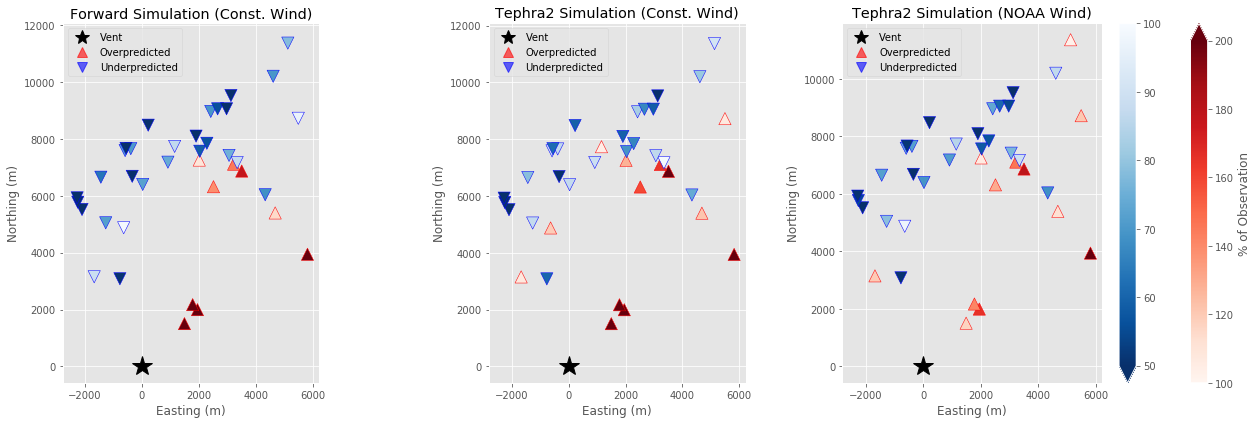

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(
        15,6), facecolor='w', edgecolor='k')
axs = axs.ravel()


vis.plot_residuals(forward_df, vent=(0,0), values="Residual",
            title="Forward Simulation (Const. Wind)", 
            plot_type = "size", ax=axs[0])
vis.plot_residuals(t2_const_df, vent=(0,0), values="Residual",
            title="Tephra2 Simulation (Const. Wind)", 
             plot_type = "size", ax=axs[1])
vis.plot_residuals(t2_df, vent=(0,0), values="Residual",
            title="Tephra2 Simulation (NOAA Wind)", 
             plot_type = "size", ax=axs[2])


plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 3, figsize=(
        18,6), facecolor='w', edgecolor='k')
axs = axs.ravel()


vis.plot_residuals(forward_df, vent=(0,0), values="Residual",
            title="Forward Simulation (Const. Wind)", 
            plot_type = "cmap", ax=axs[0], show_cbar = False)
vis.plot_residuals(t2_const_df, vent=(0,0), values="Residual",
            title="Tephra2 Simulation (Const. Wind)", 
             plot_type = "cmap", ax=axs[1], show_cbar = False)
vis.plot_residuals(t2_df, vent=(0,0), values="Residual",
            title="Tephra2 Simulation (NOAA Wind)", 
             plot_type = "cmap", ax=axs[2], show_cbar = True)


# plt.tight_layout()
plt.show()

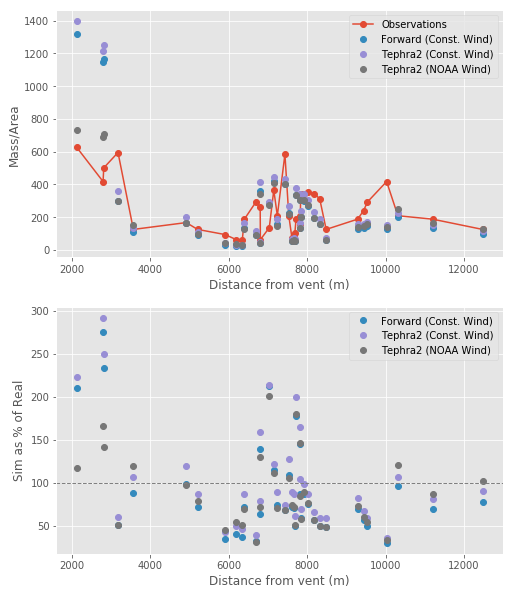

In [14]:
fig, axs = plt.subplots(2,1, figsize=(
        8,10), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].plot(obs_df["radius"].values, obs_df["MassArea"].values, 'C0o-', label="Observations")
# plt.plot(rotdf["radius"].values, rotdf["MassArea"].values, 'C1o-')
axs[0].plot(forward_df["radius"].values, forward_df["MassArea"].values, 'C1o', label="Forward (Const. Wind)")
axs[0].plot(t2_const_df["radius"].values, t2_const_df["MassArea"].values, 'C2o', label="Tephra2 (Const. Wind)")
axs[0].plot(t2_df["radius"].values, t2_df["MassArea"].values, 'C3o', label="Tephra2 (NOAA Wind)")
axs[0].legend()
axs[0].set_xlabel("Distance from vent (m)")
axs[0].set_ylabel("Mass/Area")

axs[1].plot(forward_df["radius"].values, forward_df["Residual"].values*100, 'C1o', label="Forward (Const. Wind)")
axs[1].plot(t2_const_df["radius"].values, t2_const_df["Residual"].values*100, 'C2o', label="Tephra2 (Const. Wind)")
axs[1].plot(t2_df["radius"].values, t2_df["Residual"].values*100, 'C3o', label="Tephra2 (NOAA Wind)")
axs[1].axhline(100, linestyle="--", lw=1, c="gray")
axs[1].legend()
axs[1].set_xlabel("Distance from vent (m)")
axs[1].set_ylabel("Sim as % of Real")
plt.show()

========Const. Wind Simulation========
a* = -4.58102	b* = -0.54653	            h1* = 1.65851	u* = 1.72586	v* = 2.07362	            D* = 8.29804	ftt* = 8.77307	TM* = 24.73060
a = 1.01024	b = 1.57896	            h1 = 24798.29477	u = 5.61737	v = 7.95357	            D = 4016.00000	ftt = 6458.00000	TM = 55000000000.00002
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 632
SSE: 2.0464299158275985


,Height,Suspended Mass
0,4430.75,5.357619e+09
1,5776.50,5.186425e+09
2,7122.25,4.991405e+09
3,8468.00,4.781804e+09
4,9813.75,4.559951e+09
5,11159.50,4.326241e+09
6,12505.25,4.080149e+09
7,13851.00,3.820481e+09
8,15196.75,3.545368e+09
9,16542.50,3.252077e+09


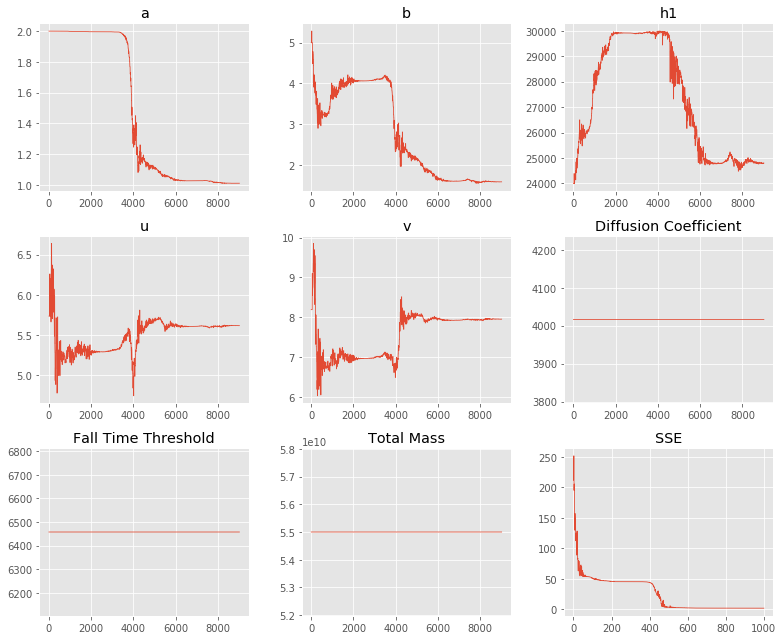

Const. Wind Simulation Run Time: 1.58594 minutes


========T2 Const. Wind Simulation========
a* = -2.92375	b* = -0.60164	            h1* = 1.15981	u* = 1.68419	v* = 2.15757	            D* = 8.29804	ftt* = 8.77307	TM* = 24.73060
a = 1.05373	b = 1.54791	            h1 = 21925.49790	u = 5.38809	v = 8.65006	            D = 4016.00000	ftt = 6458.00000	TM = 55000000000.00002
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 627
SSE: 9.226986525620184


,Height,Suspended Mass
0,4430.75,5.721234e+09
1,5776.50,5.683527e+09
2,7122.25,5.538278e+09
3,8468.00,5.338366e+09
4,9813.75,5.099696e+09
5,11159.50,4.828049e+09
6,12505.25,4.524746e+09
7,13851.00,4.188216e+09
8,15196.75,3.814109e+09
9,16542.50,3.394324e+09


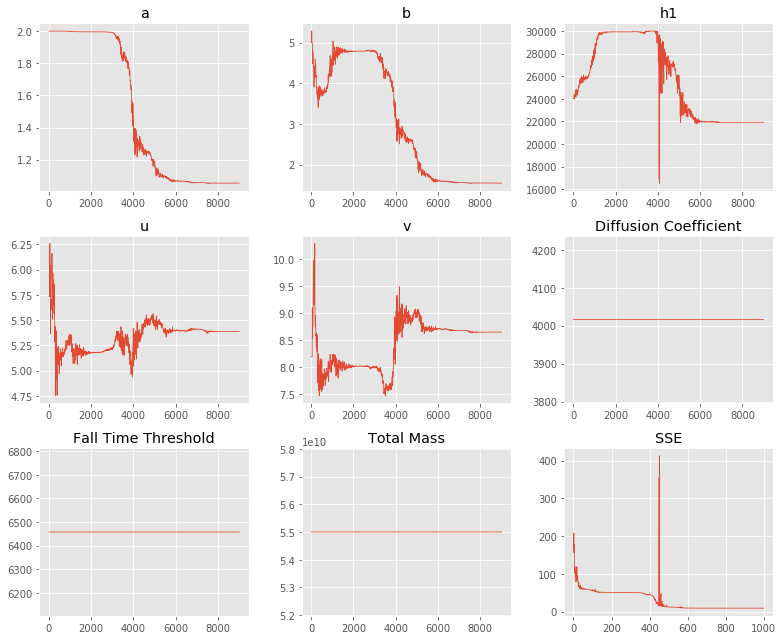

T2 Const. Wind Simulation Run Time: 1.57682 minutes


========T2 NOAA Wind Simulation========
a* = -1.83848	b* = -2.27917	            h1* = 3.19802	u* = 1.72038	v* = 1.99358	            D* = 8.29804	ftt* = 8.77307	TM* = 24.73060
a = 1.15906	b = 1.10237	            h1 = 28799.39105	u = 5.58668	v = 7.34174	            D = 4016.00000	ftt = 6458.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 499
SSE: 221.61921201944833


,Height,Suspended Mass
0,4430.75,2.314579e+09
1,5776.50,2.569378e+09
2,7122.25,2.723700e+09
3,8468.00,2.832581e+09
4,9813.75,2.914420e+09
5,11159.50,2.977681e+09
6,12505.25,3.026903e+09
7,13851.00,3.064716e+09
8,15196.75,3.092661e+09
9,16542.50,3.111566e+09


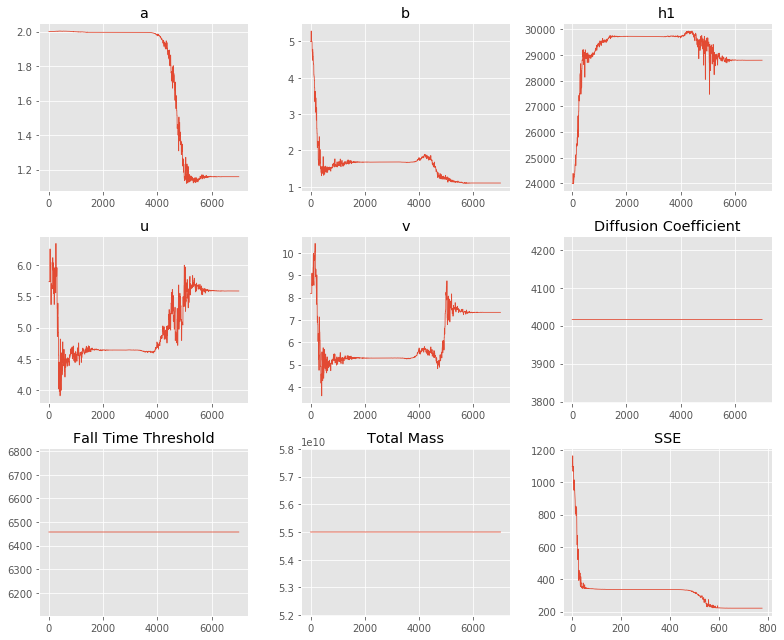

T2 NOAA Wind Simulation Run Time: 1.40260 minutes


========Observation Data========
a* = -1.43611	b* = -2.08708	            h1* = 3.18093	u* = 0.74163	v* = 1.71877	            D* = 8.29804	ftt* = 8.77307	TM* = 24.73060
a = 1.23785	b = 1.12405	            h1 = 28779.12212	u = 2.09936	v = 5.57768	            D = 4016.00000	ftt = 6458.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 523
SSE: 749.9795639361648


,Height,Suspended Mass
0,4430.75,2.005754e+09
1,5776.50,2.348633e+09
2,7122.25,2.567148e+09
3,8468.00,2.727167e+09
4,9813.75,2.851469e+09
5,11159.50,2.950781e+09
6,12505.25,3.030958e+09
7,13851.00,3.095447e+09
8,15196.75,3.146303e+09
9,16542.50,3.184659e+09


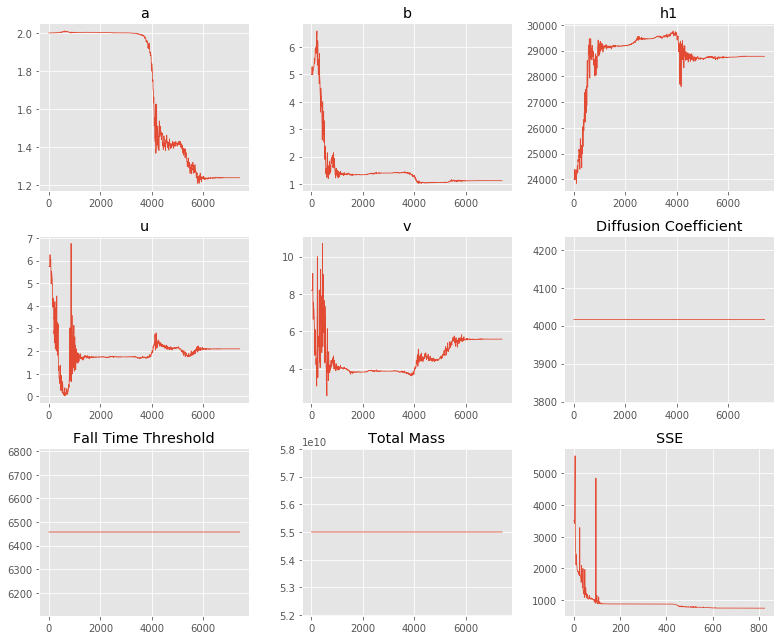

Observation Data Run Time: 1.44167 minutes


Total Run Time: 6.00703 minutes


In [19]:
# priors_vals = {
#     "a": 2,
#     "b": 5,
#     "h1": 18000,
#     "u": 5,
#     "v": 6,
#     "D": 4000,
#     "ftt": 6000,
#     "M": config["ERUPTION_MASS"]
# }

priors_vals = {
    "a": 2,
    "b": 5,
    "h1": config["PLUME_HEIGHT"],
    "u": u,
    "v": v,
    "D": config["DIFFUSION_COEFFICIENT"],
    "ftt": config["FALL_TIME_THRESHOLD"],
    "M": config["ERUPTION_MASS"]
}

invert_params = {
    "a" : True,
    "b" : True,
    "h1" : True,
    "u": True,
    "v": True,
    "D": False,
    "ftt": False,
    "M": False
}

H = 30000

t_tot = process_time()
single_run_time = 0
wind_angle = np.radians(55.5)

names = ["Const. Wind Simulation", 
         "T2 Const. Wind Simulation",
         "T2 NOAA Wind Simulation", 
         "Observation Data"]
data_sets = [forward_df, t2_const_df, t2_df, obs_df]

inverted_masses_list = []
params_list = []
sim_params = {
    "a": config["ALPHA"],
    "b": config["BETA"],
    "h1": config["PLUME_HEIGHT"],
    "u": u,
    "v": v,
    "D": config["DIFFUSION_COEFFICIENT"],
    "ftt": config["FALL_TIME_THRESHOLD"],
    "M": config["ERUPTION_MASS"]
}
params_list += [sim_params]
for name, df in zip(names, data_sets):
    t = process_time()
    
    print("========%s========"%name)
    out = gaussian_stack_inversion(
        df, len(df), 20, config["VENT_ELEVATION"], 
        H, 2500, phi_steps,
        invert_params=invert_params,
        priors=priors_vals,
        column_cap=H)
    inversion_table, params, sol, sse, plume_trace, param_trace, sse_trace = out
    inv_mass = inversion_table["Suspended Mass"].values
    inverted_masses_list += [inv_mass]
    params_list += [params]
    display(inversion_table)
    plume_trace = np.array(plume_trace)
    param_trace = np.array(param_trace)
    fig, axs = plt.subplots(3,3, figsize=(
            11, 9), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    axs[0].plot(plume_trace[:,0], linewidth=.8)
    axs[0].set_title("a")

    axs[1].plot(plume_trace[:,1], linewidth=.8)
    axs[1].set_title("b")

    axs[2].plot(plume_trace[:,2], linewidth=.8)
    axs[2].set_title("h1")
    
    axs[3].plot(param_trace[:,0], linewidth=.8)
    axs[3].set_title("u")

    axs[4].plot(param_trace[:,1], linewidth=.8)
    axs[4].set_title("v")
    
    axs[5].plot(param_trace[:,2], linewidth=.8)
    axs[5].set_title("Diffusion Coefficient")
    
    axs[6].plot(param_trace[:,3], linewidth=.8)
    axs[6].set_title("Fall Time Threshold")
    
    axs[7].plot(param_trace[:,4], linewidth=.8)
    axs[7].set_title("Total Mass")

    axs[8].plot(sse_trace, linewidth=.8)
    axs[8].set_title("SSE")

    plt.tight_layout()
    # plt.savefig("colima/real_trace.png", dpi=200, format='png')
    plt.show()
    
    run_time = process_time() - t
    print("%s Run Time: %.5f minutes\n\n"%(name, run_time/60))


total_run_time = process_time() - t_tot

print("Total Run Time: %.5f minutes"%(total_run_time/60))

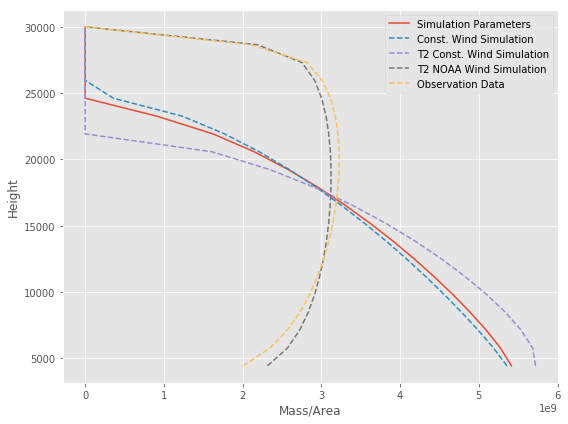

,Dataset,a,b,h1,u,v,D,ftt,M
0,Simulation Parameters,1.020000,1.560000,24000.000000,5.735764,8.191520,4016.0,6458.0,5.500000e+10
1,Const. Wind Simulation,1.010244,1.578958,24798.294774,5.617375,7.953567,4016.0,6458.0,5.500000e+10
2,T2 Const. Wind Simulation,1.053732,1.547914,21925.497900,5.388090,8.650064,4016.0,6458.0,5.500000e+10
3,T2 NOAA Wind Simulation,1.159059,1.102369,28799.391050,5.586677,7.341741,4016.0,6458.0,5.500000e+10
4,Observation Data,1.237852,1.124048,28779.122118,2.099364,5.577681,4016.0,6458.0,5.500000e+10


In [20]:
fig, ax1 = plt.subplots(1,1, figsize=(
    8, 6), facecolor='w', edgecolor='k')

q_dist = beta(config["ALPHA"],config["BETA"])

q_mass = mass_dist_in_plume(config["ALPHA"],config["BETA"], config["VENT_ELEVATION"], 
            config["PLUME_HEIGHT"],
            inversion_table["Height"],
            config["ERUPTION_MASS"])

ax1.plot(q_mass, inversion_table["Height"], label="Simulation Parameters")
for name, mass in zip(names, inverted_masses_list):
    ax1.plot(mass, 
         inversion_table["Height"], 
         '--', label=name)
ax1.legend()
# ax1.set_title("Mass in Column as inverted from various datasets")
ax1.set_ylabel("Height")
ax1.set_xlabel("Mass/Area")

plt.tight_layout()
plt.show()
params_df = pd.DataFrame(params_list)
params_df["Dataset"] = ["Simulation Parameters"] + names
params_df = params_df[["Dataset", "a", "b", "h1", "u", "v", "D", "ftt", "M"]]
display(params_df)

In [14]:
H = 30000

def exp_trunc(mean, bottom=1):
    return expon.rvs(scale=(mean-bottom)) + bottom

def exp_wind(mean):
    return expon.rvs(scale=(mean))

def col_truncnorm(mean, top=H):
    bottom = 5000
    std = (top - bottom)/4
    standard_a, standard_b = (bottom - mean) / std, (top - mean) / std
    return truncnorm.rvs(standard_a, standard_b, loc=mean, scale=std)

def diff_truncnorm(mean, top=1e6, bottom=10):
    std = (top - bottom)/4
    standard_a, standard_b = (bottom - mean) / std, (top - mean) / std
    return truncnorm.rvs(standard_a, standard_b, loc=mean, scale=std)

# def mass_truncnorm(mean):
#     top = 1e15
#     bottom = 1e3
#     std = (top - bottom)/6
#     standard_a, standard_b = (bottom - mean) / std, (top - mean) / std
#     return truncnorm.rvs(standard_a, standard_b, loc=mean, scale=std)


In [15]:
param_config = {
    "D": {
        "value":4000,
        "invert":True,
        "stage":0,
        "sample_function": diff_truncnorm
    },
    "ftt": {
        "value":6000,
        "invert":False,
        "sample_function": diff_truncnorm
    },
    "a": {
        "value":2,
        "invert":True,
        "stage":1,
        "sample_function": exp_trunc
    },
    "b": {
        "value":2,
        "invert":True,
        "stage":1,
        "sample_function": exp_trunc
    },
    "h1": {
        "value":20000,
        "invert":True,
        "stage":1,
        "sample_function": col_truncnorm
    },
    "u": {
        "value":5,
        "invert":True,
        "stage":2,
        "sample_function": exp_wind
    },
    "v": {
        "value":6,
        "invert":True,
        "stage":2,
        "sample_function": exp_wind
    },
    "M": {
        "value":config["ERUPTION_MASS"],
        "invert":True,
        "stage":3,
        "sample_function": exp_wind
    }
}
param_config_df = pd.DataFrame(param_config)
display(param_config_df.T)

stages = {
    0: {
        "runs":5,
        "name":"Diffusion Stage"
    },
    1: {
        "runs":3,
        "name":"Column Stage"
    },
    2: {
        "runs":3,
        "name":"Wind Stage"
    },
    3: {
        "runs":3,
        "name":"Mass Stage"
    },
}

display(stages)
stages_df = pd.DataFrame(stages)
display(stages_df.T)


# param_config = {
#     "D": {
#         "value":4000,
#         "invert":True,
#         "stage":0,
#         "sample_function": diff_truncnorm
#     },
#     "ftt": {
#         "value":6000,
#         "invert":True,
#         "stage":0,
#         "sample_function": diff_truncnorm
#     },
#     "a": {
#         "value":2,
#         "invert":True,
#         "stage":0,
#         "sample_function": exp_trunc
#     },
#     "b": {
#         "value":2,
#         "invert":True,
#         "stage":0,
#         "sample_function": exp_trunc
#     },
#     "h1": {
#         "value":20000,
#         "invert":True,
#         "stage":0,
#         "sample_function": col_truncnorm
#     },
#     "u": {
#         "value":5,
#         "invert":True,
#         "stage":0,
#         "sample_function": exp_wind
#     },
#     "v": {
#         "value":6,
#         "invert":True,
#         "stage":0,
#         "sample_function": exp_wind
#     },
#     "M": {
#         "value":config["ERUPTION_MASS"],
#         "invert":True,
#         "stage":0,
#         "sample_function": exp_wind
#     }
# }
# param_config_df = pd.DataFrame(param_config)
# display(param_config_df.T)

# stages = {
#     0: {
#         "runs":3,
#         "name":"Diffusion Stage"
#     }
# }

# display(stages)
# stages_df = pd.DataFrame(stages)
# display(stages_df.T)

,invert,sample_function,stage,value
D,True,<function diff_truncnorm at 0x000002EE658F8B70>,0,4000
ftt,False,<function diff_truncnorm at 0x000002EE658F8B70>,NaN,6000
a,True,<function exp_trunc at 0x000002EE6421C0D0>,1,2
b,True,<function exp_trunc at 0x000002EE6421C0D0>,1,2
h1,True,<function col_truncnorm at 0x000002EE658F8AE8>,1,20000
u,True,<function exp_wind at 0x000002EE658F8950>,2,5
v,True,<function exp_wind at 0x000002EE658F8950>,2,6
M,True,<function exp_wind at 0x000002EE658F8950>,3,5.5e+10


{0: {'runs': 3, 'name': 'Diffusion Stage'},
 1: {'runs': 3, 'name': 'Column Stage'},
 2: {'runs': 3, 'name': 'Wind Stage'},
 3: {'runs': 3, 'name': 'Mass Stage'}}

,name,runs
0,Diffusion Stage,3
1,Column Stage,3
2,Wind Stage,3
3,Mass Stage,3


In [16]:
for i in stages: stages[i]["params"] = []
    
for j, param in param_config.items():
    if param["invert"]:
        stages[param["stage"]]["params"] += [j]
display(stages)


dict_list = []
prior_dict = {}
prior_dict["Parameter"] = "Priors"
for p in param_config.keys():
    prior_dict[p] = param_config[p]["value"]
    
dict_list.append(prior_dict)

{0: {'runs': 3, 'name': 'Diffusion Stage', 'params': ['D']},
 1: {'runs': 3, 'name': 'Column Stage', 'params': ['a', 'b', 'h1']},
 2: {'runs': 3, 'name': 'Wind Stage', 'params': ['u', 'v']},
 3: {'runs': 3, 'name': 'Mass Stage', 'params': ['M']}}

Diffusion Stage=================================================================
Inverting:	|	D	|
Prior Mean:	|	4000	|
RUN 0 (SLOW) ---------------------------------------------------------------
Prior Sample:	|	285173	|
a* = 0.00000	b* = 0.00000	            h1* = 0.90272	u* = 1.60944	v* = 1.79176	            D* = 9.26118	ftt* = 8.69951	TM* = 24.73060
a = 2.00000	b = 2.00000	            h1 = 20000.00000	u = 5.00000	v = 6.00000	            D = 10521.48987	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 18
SSE: 1175.9299003899348
Posterior:	|	10521.5	|


,Height,Suspended Mass
0,4430.75,1.925880e+09
1,5776.50,3.518827e+09
2,7122.25,4.778843e+09
3,8468.00,5.705926e+09
4,9813.75,6.300076e+09
5,11159.50,6.561295e+09
6,12505.25,6.489581e+09
7,13851.00,6.084935e+09
8,15196.75,5.347357e+09
9,16542.50,4.276847e+09


Inverting:	|	D	|
Prior Mean:	|	4000	|
RUN 1 (SLOW) ---------------------------------------------------------------
Prior Sample:	|	35342.7	|
a* = 0.00000	b* = 0.00000	            h1* = 0.90272	u* = 1.60944	v* = 1.79176	            D* = 9.26116	ftt* = 8.69951	TM* = 24.73060
a = 2.00000	b = 2.00000	            h1 = 20000.00000	u = 5.00000	v = 6.00000	            D = 10521.30281	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 16
SSE: 1175.9298999016
Posterior:	|	10521.3	|


,Height,Suspended Mass
0,4430.75,1.925880e+09
1,5776.50,3.518827e+09
2,7122.25,4.778843e+09
3,8468.00,5.705926e+09
4,9813.75,6.300076e+09
5,11159.50,6.561295e+09
6,12505.25,6.489581e+09
7,13851.00,6.084935e+09
8,15196.75,5.347357e+09
9,16542.50,4.276847e+09


Inverting:	|	D	|
Prior Mean:	|	4000	|
RUN 2 (SLOW) ---------------------------------------------------------------
Prior Sample:	|	130295	|
a* = 0.00000	b* = 0.00000	            h1* = 0.90272	u* = 1.60944	v* = 1.79176	            D* = 9.26117	ftt* = 8.69951	TM* = 24.73060
a = 2.00000	b = 2.00000	            h1 = 20000.00000	u = 5.00000	v = 6.00000	            D = 10521.43316	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 17
SSE: 1175.9299001845666
Posterior:	|	10521.4	|


,Height,Suspended Mass
0,4430.75,1.925880e+09
1,5776.50,3.518827e+09
2,7122.25,4.778843e+09
3,8468.00,5.705926e+09
4,9813.75,6.300076e+09
5,11159.50,6.561295e+09
6,12505.25,6.489581e+09
7,13851.00,6.084935e+09
8,15196.75,5.347357e+09
9,16542.50,4.276847e+09


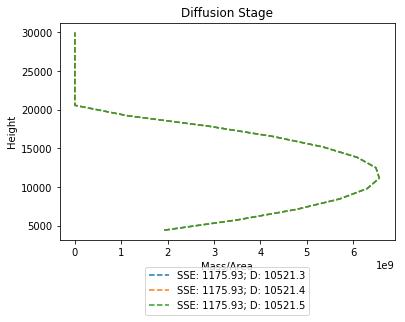

Updating params
Diffusion Stage Run Time: 0.17135 minutes


Column Stage====================================================================
Inverting:	|	a	|	b	|	h1	|
Prior Mean:	|	2	|	2	|	20000	|
RUN 0 (FAST) ---------------------------------------------------------------
Prior Sample:	|	1.13463	|	1.1332	|	27079.2	|
{'a': 1.134628412739315, 'b': 1.1332019968320002, 'h1': 27079.165374014978}
[True, True, True]
[False, False, False]
['a', 'b', 'h1']
a* = -2.92989	b* = -0.29322            	h1* = 1.37050
a = 1.05340	b = 1.74586	h1 = 23271.24445
Success: True, Optimization terminated successfully.
Iterations: 87
SSE: 849.0481784027734
{'D': 10521.302812600885, 'ftt': 6000, 'u': 5, 'v': 6, 'M': 55000000000.0, 'a': 1.134628412739315, 'b': 1.1332019968320002, 'h1': 27079.165374014978}
{'a': 1.053402647361973, 'b': 1.745857178948358, 'h1': 23271.244452765033}
{'D': 10521.302812600885, 'ftt': 6000, 'u': 5, 'v': 6, 'M': 55000000000.0, 'a': 1.053402647361973, 'b': 1.745857178948358, 'h1': 23271.2

,Height,Suspended Mass
0,4430.75,5.962943e+09
1,5776.50,5.855059e+09
2,7122.25,5.636473e+09
3,8468.00,5.364073e+09
4,9813.75,5.055881e+09
5,11159.50,4.719508e+09
6,12505.25,4.358323e+09
7,13851.00,3.973403e+09
8,15196.75,3.564195e+09
9,16542.50,3.128579e+09


Inverting:	|	a	|	b	|	h1	|
Prior Mean:	|	2	|	2	|	20000	|
RUN 1 (FAST) ---------------------------------------------------------------
Prior Sample:	|	1.38051	|	2.38299	|	24156.6	|
{'a': 1.380513071068721, 'b': 2.382994777473195, 'h1': 24156.644986743617}
[True, True, True]
[False, False, False]
['a', 'b', 'h1']
a* = -2.93146	b* = -0.29331            	h1* = 1.37050
a = 1.05332	b = 1.74579	h1 = 23271.24912
Success: True, Optimization terminated successfully.
Iterations: 139
SSE: 849.0481661075028
{'D': 10521.302812600885, 'ftt': 6000, 'u': 5, 'v': 6, 'M': 55000000000.0, 'a': 1.380513071068721, 'b': 2.382994777473195, 'h1': 24156.644986743617}
{'a': 1.0533190861700767, 'b': 1.7457880612957055, 'h1': 23271.249119998738}
{'D': 10521.302812600885, 'ftt': 6000, 'u': 5, 'v': 6, 'M': 55000000000.0, 'a': 1.0533190861700767, 'b': 1.7457880612957055, 'h1': 23271.249119998738}
Posterior:	|	1.05332	|	1.74579	|	23271.2	|


,Height,Suspended Mass
0,4430.75,5.963481e+09
1,5776.50,5.855279e+09
2,7122.25,5.636525e+09
3,8468.00,5.364025e+09
4,9813.75,5.055775e+09
5,11159.50,4.719372e+09
6,12505.25,4.358177e+09
7,13851.00,3.973262e+09
8,15196.75,3.564072e+09
9,16542.50,3.128483e+09


Inverting:	|	a	|	b	|	h1	|
Prior Mean:	|	2	|	2	|	20000	|
RUN 2 (FAST) ---------------------------------------------------------------
Prior Sample:	|	1.28249	|	1.13241	|	22154.1	|
{'a': 1.2824945535960204, 'b': 1.132407011536877, 'h1': 22154.07682592689}
[True, True, True]
[False, False, False]
['a', 'b', 'h1']
a* = -2.93160	b* = -0.29333            	h1* = 1.37050
a = 1.05331	b = 1.74577	h1 = 23271.24999
Success: True, Optimization terminated successfully.
Iterations: 156
SSE: 849.0481658415076
{'D': 10521.302812600885, 'ftt': 6000, 'u': 5, 'v': 6, 'M': 55000000000.0, 'a': 1.2824945535960204, 'b': 1.132407011536877, 'h1': 22154.07682592689}
{'a': 1.0533116463769643, 'b': 1.7457740508737687, 'h1': 23271.24999253017}
{'D': 10521.302812600885, 'ftt': 6000, 'u': 5, 'v': 6, 'M': 55000000000.0, 'a': 1.0533116463769643, 'b': 1.7457740508737687, 'h1': 23271.24999253017}
Posterior:	|	1.05331	|	1.74577	|	23271.2	|


,Height,Suspended Mass
0,4430.75,5.963504e+09
1,5776.50,5.855276e+09
2,7122.25,5.636512e+09
3,8468.00,5.364008e+09
4,9813.75,5.055757e+09
5,11159.50,4.719356e+09
6,12505.25,4.358164e+09
7,13851.00,3.973254e+09
8,15196.75,3.564070e+09
9,16542.50,3.128486e+09


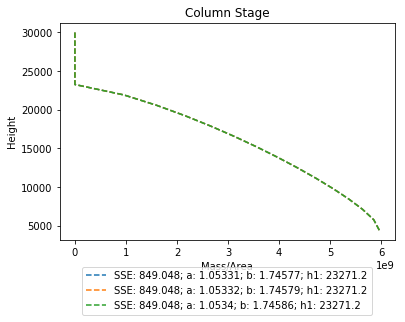

Updating params
Column Stage Run Time: 0.02682 minutes


Wind Stage======================================================================
Inverting:	|	u	|	v	|
Prior Mean:	|	5	|	6	|
RUN 0 (SLOW) ---------------------------------------------------------------
Prior Sample:	|	6.91384	|	6.2317	|
a* = -2.93160	b* = -0.29333	            h1* = 1.37050	u* = 0.96225	v* = 2.02863	            D* = 9.26116	ftt* = 8.69951	TM* = 24.73060
a = 1.05331	b = 1.74577	            h1 = 23271.24999	u = 2.61758	v = 7.60369	            D = 10521.30281	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 35
SSE: 721.5755324886261
Posterior:	|	2.61758	|	7.60369	|


,Height,Suspended Mass
0,4430.75,5.963504e+09
1,5776.50,5.855276e+09
2,7122.25,5.636512e+09
3,8468.00,5.364008e+09
4,9813.75,5.055757e+09
5,11159.50,4.719356e+09
6,12505.25,4.358164e+09
7,13851.00,3.973254e+09
8,15196.75,3.564070e+09
9,16542.50,3.128486e+09


Inverting:	|	u	|	v	|
Prior Mean:	|	5	|	6	|
RUN 1 (SLOW) ---------------------------------------------------------------
Prior Sample:	|	3.73918	|	1.40842	|
a* = -2.93160	b* = -0.29333	            h1* = 1.37050	u* = 0.96222	v* = 2.02863	            D* = 9.26116	ftt* = 8.69951	TM* = 24.73060
a = 1.05331	b = 1.74577	            h1 = 23271.24999	u = 2.61750	v = 7.60363	            D = 10521.30281	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 58
SSE: 721.5755327709992
Posterior:	|	2.6175	|	7.60363	|


,Height,Suspended Mass
0,4430.75,5.963504e+09
1,5776.50,5.855276e+09
2,7122.25,5.636512e+09
3,8468.00,5.364008e+09
4,9813.75,5.055757e+09
5,11159.50,4.719356e+09
6,12505.25,4.358164e+09
7,13851.00,3.973254e+09
8,15196.75,3.564070e+09
9,16542.50,3.128486e+09


Inverting:	|	u	|	v	|
Prior Mean:	|	5	|	6	|
RUN 2 (SLOW) ---------------------------------------------------------------
Prior Sample:	|	7.81844	|	13.7144	|
a* = -2.93160	b* = -0.29333	            h1* = 1.37050	u* = 0.96227	v* = 2.02863	            D* = 9.26116	ftt* = 8.69951	TM* = 24.73060
a = 1.05331	b = 1.74577	            h1 = 23271.24999	u = 2.61764	v = 7.60363	            D = 10521.30281	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 49
SSE: 721.5755324907072
Posterior:	|	2.61764	|	7.60363	|


,Height,Suspended Mass
0,4430.75,5.963504e+09
1,5776.50,5.855276e+09
2,7122.25,5.636512e+09
3,8468.00,5.364008e+09
4,9813.75,5.055757e+09
5,11159.50,4.719356e+09
6,12505.25,4.358164e+09
7,13851.00,3.973254e+09
8,15196.75,3.564070e+09
9,16542.50,3.128486e+09


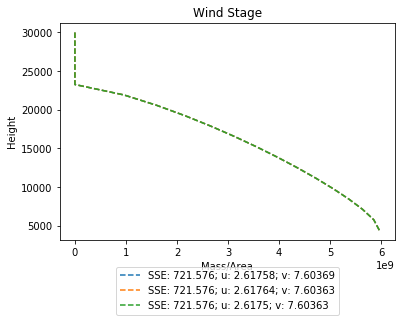

Updating params
Wind Stage Run Time: 0.43568 minutes


Mass Stage======================================================================
Inverting:	|	M	|
Prior Mean:	|	5.5e+10	|
RUN 0 (SLOW) ---------------------------------------------------------------
Prior Sample:	|	1.43159e+10	|
a* = -2.93160	b* = -0.29333	            h1* = 1.37050	u* = 0.96225	v* = 2.02863	            D* = 9.26116	ftt* = 8.69951	TM* = 24.81920
a = 1.05331	b = 1.74577	            h1 = 23271.24999	u = 2.61758	v = 7.60369	            D = 10521.30281	ftt = 6000.00000	TM = 60095603946.54778
Success: True, Optimization terminated successfully.
Iterations: 15
SSE: 706.0261974017449
Posterior:	|	6.00956e+10	|


,Height,Suspended Mass
0,4430.75,6.516006e+09
1,5776.50,6.397752e+09
2,7122.25,6.158720e+09
3,8468.00,5.860969e+09
4,9813.75,5.524160e+09
5,11159.50,5.156592e+09
6,12505.25,4.761936e+09
7,13851.00,4.341366e+09
8,15196.75,3.894271e+09
9,16542.50,3.418332e+09


Inverting:	|	M	|
Prior Mean:	|	5.5e+10	|
RUN 1 (SLOW) ---------------------------------------------------------------
Prior Sample:	|	3.23275e+10	|
a* = -2.93160	b* = -0.29333	            h1* = 1.37050	u* = 0.96225	v* = 2.02863	            D* = 9.26116	ftt* = 8.69951	TM* = 24.81915
a = 1.05331	b = 1.74577	            h1 = 23271.24999	u = 2.61758	v = 7.60369	            D = 10521.30281	ftt = 6000.00000	TM = 60092735864.37724
Success: True, Optimization terminated successfully.
Iterations: 15
SSE: 706.0261970440722
Posterior:	|	6.00927e+10	|


,Height,Suspended Mass
0,4430.75,6.515695e+09
1,5776.50,6.397447e+09
2,7122.25,6.158426e+09
3,8468.00,5.860689e+09
4,9813.75,5.523896e+09
5,11159.50,5.156346e+09
6,12505.25,4.761709e+09
7,13851.00,4.341158e+09
8,15196.75,3.894085e+09
9,16542.50,3.418169e+09


Inverting:	|	M	|
Prior Mean:	|	5.5e+10	|
RUN 2 (SLOW) ---------------------------------------------------------------
Prior Sample:	|	7.94032e+09	|
a* = -2.93160	b* = -0.29333	            h1* = 1.37050	u* = 0.96225	v* = 2.02863	            D* = 9.26116	ftt* = 8.69951	TM* = 24.81916
a = 1.05331	b = 1.74577	            h1 = 23271.24999	u = 2.61758	v = 7.60369	            D = 10521.30281	ftt = 6000.00000	TM = 60092885744.13797
Success: True, Optimization terminated successfully.
Iterations: 16
SSE: 706.0261968393302
Posterior:	|	6.00929e+10	|


,Height,Suspended Mass
0,4430.75,6.515712e+09
1,5776.50,6.397463e+09
2,7122.25,6.158441e+09
3,8468.00,5.860704e+09
4,9813.75,5.523910e+09
5,11159.50,5.156359e+09
6,12505.25,4.761721e+09
7,13851.00,4.341169e+09
8,15196.75,3.894095e+09
9,16542.50,3.418178e+09


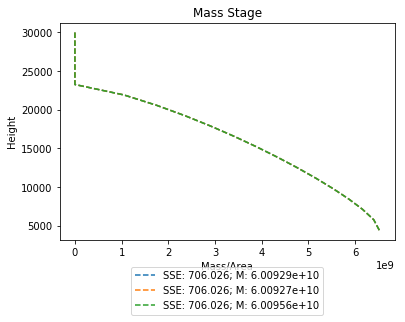

Updating params
Mass Stage Run Time: 0.15521 minutes


Total Run Time: 0.78906 minutes


In [17]:

log="verb"
data = obs_df
full_iterations = 1
########################################################


t_tot = process_time()
single_run_time = 0

    
for full_run in range(full_iterations):
    for stage in stages.values():
        t = process_time()
        inverted_masses_list = []
        params_list = []
        sse_list = []
        if log=="verb": print("%s%s"%(stage["name"], '='*(80-len(stage["name"]))))
        param_dict = {}
        
        for run in range(stage["runs"]):
            prior_samples = {}
            invert = {}
            for j, param in param_config.items():
                prior_samples[j] = param["value"]
                invert[j] = False
                if j in stage["params"]:
                    invert[j] = True
                    prior_samples[j] = param["sample_function"](param["value"])
            if log=="verb": 
                print("Inverting:\t|\t%s\t|"%"\t|\t".join(stage["params"]))
                print("Prior Mean:\t|\t%s\t|"%"\t|\t".join(
                    ["%g"%(param_config[p]["value"]) for p in stage["params"]]))

            slow_params = ["D", "ftt", "u", "v", "M"]
            if [i for i in slow_params if i in stage["params"]]:
                if log=="verb": 
                    print("RUN %d (SLOW) %s"%(run, '-'*(80-17)))
                inversion_function = gaussian_stack_inversion
            else:
                print("RUN %d (FAST) %s"%(run, '-'*(80-17)))
                inversion_function = gaussian_stack_plume_inversion
            print("Prior Sample:\t|\t%s\t|"%"\t|\t".join(
                    ["%g"%(prior_samples[p]) for p in stage["params"]]))
            out = inversion_function(
                data, len(data), 20, config["VENT_ELEVATION"], 
                H, 2500, phi_steps,
                invert_params=invert,
                priors=prior_samples,
                column_cap=H, out="verb")
            inversion_table, params, sol, sse, plume_trace, param_trace, sse_trace = out

            if log=="verb": 
                print("Posterior:\t|\t%s\t|"%"\t|\t".join(
                    ["%g"%(params[p]) for p in stage["params"]]))
                display(inversion_table)

            inverted_masses_list += [inversion_table["Suspended Mass"].values]
            params_list += [params]
            sse_list += [sse]
        best = np.argsort(sse_list)
        fig, ax1 = plt.subplots(1,1, figsize=(6, 4), facecolor='w', edgecolor='k')
#         q_mass = mass_dist_in_plume(config["ALPHA"],config["BETA"], config["VENT_ELEVATION"], 
#                 config["PLUME_HEIGHT"],
#                 inversion_table["Height"],
#                 config["ERUPTION_MASS"])
#         ax1.plot(q_mass, inversion_table["Height"], label="Actual Column")
        for i in best:
            label = "SSE: %g; %s"%(sse_list[i], "; ".join(["%s: %g"%(p, params_list[i][p]) for p in stage["params"]]))
            ax1.plot(inverted_masses_list[i], 
                     inversion_table["Height"], 
                     '--', label=label)
        ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1))
        ax1.set_title(stage["name"])
        ax1.set_ylabel("Height")
        ax1.set_xlabel("Mass/Area")
        plt.show()
        print("Updating params")
        for p in stage["params"]:
            param_config[p]["value"] = params_list[best[0]][p]
            
        param_dict = params_list[best[0]].copy()
        param_dict["Parameter"] = stage["name"]

        dict_list.append(param_dict)
        best_run = best[0]
        run_time = process_time() - t
        print("%s Run Time: %.5f minutes\n\n"%(stage["name"], run_time/60))

# fig, ax1 = plt.subplots(1,1, figsize=(6, 4), facecolor='w', edgecolor='k')

# ax1.plot(inverted_masses_list[best_run], 
#          inversion_table["Height"], 
#          '-', label=label)
# # ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1))
# ax1.set_title("Best fit plume")
# ax1.set_ylabel("Height")
# ax1.set_xlabel("Mass/Area")
# plt.show()

# final_table = pd.DataFrame(dict_list)
# final_table = final_table.set_index("Parameter").T
# pd.options.display.float_format = '{:,g}'.format
# display(final_table)
total_run_time = process_time() - t_tot
print("Total Run Time: %.5f minutes"%(total_run_time/60))



In [18]:
ax1.plot(inverted_masses_list[best_run], 
         inversion_table["Height"], 
         '-', label=label)
# ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1))
ax1.set_title("Best fit plume")
ax1.set_ylabel("Height")
ax1.set_xlabel("Mass/Area")
plt.show()

final_table = pd.DataFrame(dict_list)
final_table = final_table.set_index("Parameter").T
pd.options.display.float_format = '{:,g}'.format
display(final_table)

Parameter,Priors,Diffusion Stage,Column Stage,Wind Stage,Mass Stage
D,"4,000","10,521.3","10,521.3","10,521.3","10,521.3"
M,5.5e+10,5.5e+10,5.5e+10,5.5e+10,6.00929e+10
a,2,2,1.05331,1.05331,1.05331
b,2,2,1.74577,1.74577,1.74577
ftt,"6,000","6,000","6,000","6,000","6,000"
h1,"20,000","20,000","23,271.2","23,271.2","23,271.2"
u,5,5,5,2.61758,2.61758
v,6,6,6,7.60369,7.60369
